In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
df = pd.read_csv('data/advertising_data.csv')
# Delete strings with ad_chanel = other
df = df[df['ad_channel'] != 'other']
df.head()

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,219687,interest,150000,0.0,Android,banner,0.5
1,897013,interest,150000,0.0,Android,organic_traffic,0.0
2,242700,interest,150000,0.0,Android,organic_traffic,0.0
3,143856,interest,150000,0.0,Android,organic_traffic,0.0
4,26717,consideration,150000,0.0,Android,organic_traffic,0.0


# Data Cleaning

Table may contain fraud data. If user performs more than 1 action in the same timestamp, it is considered as fraud.

In [3]:
# How many actions the user performs at one time
df_actions = df.groupby(['user_id', 'timestamp']).agg({'funnel_stage': 'count'}).sort_values('funnel_stage', ascending=False).reset_index()
df_actions.head()

,user_id,timestamp,funnel_stage
0,503272,185866,2
1,562461,177184,2
2,103625,185829,2
3,606357,150830,2
4,657167,207956,2


In [4]:
# Store fraud data to a separate dataframe
fraud = df_actions[df_actions['funnel_stage'] > 1]
fraud_df =  df[df['user_id'].isin(fraud['user_id'])].sort_values('user_id').reset_index(drop=True)
fraud_df

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,580,interest,164474,0.0,iOS,search,1.5
1,580,interest,164474,0.0,Android,search,1.5
2,580,interest,164473,0.0,iOS,search,1.5
3,580,interest,177643,0.0,iOS,partner_network,1.0
4,580,interest,177644,0.0,Android,partner_network,1.0
...,...,...,...,...,...,...,...
15522,920699,intent,164171,0.0,iOS,partner_network,1.0
15523,920699,intent,164172,0.0,iOS,partner_network,1.0
15524,920699,intent,194725,0.0,Android,search,1.5
15525,920699,interest,187601,0.0,Android,partner_network,1.0


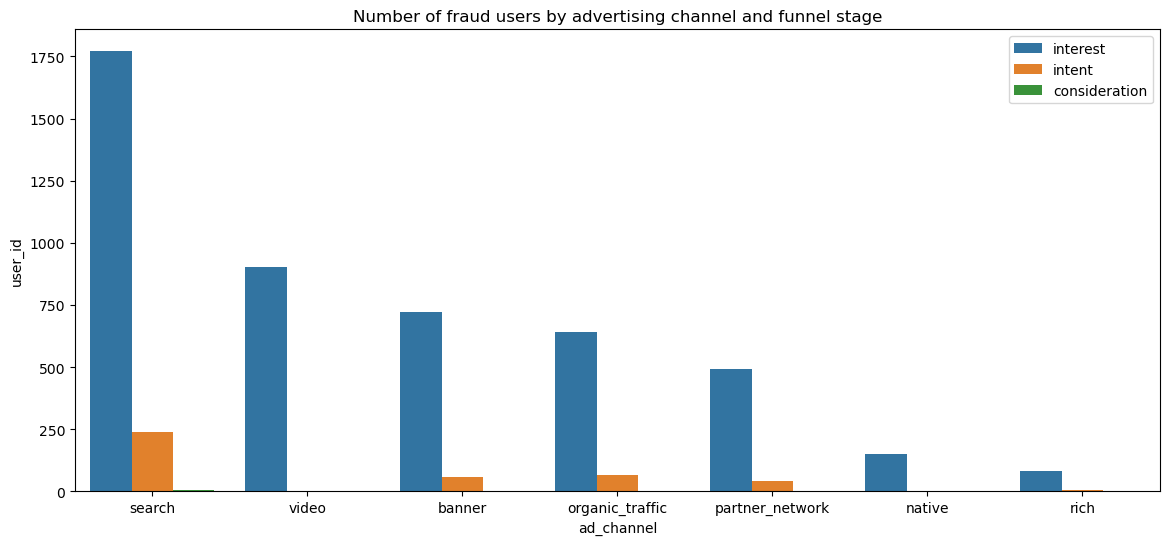

In [5]:
# Number of fraud users by advertising channel and funnel stage
df_funnel = fraud_df.groupby(['ad_channel', 'funnel_stage']).agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
plt.figure(figsize=(14, 6))

sns.barplot(x='ad_channel', y='user_id', hue='funnel_stage', data=df_funnel)
plt.title('Number of fraud users by advertising channel and funnel stage')
plt.legend(loc='upper right')
plt.show()

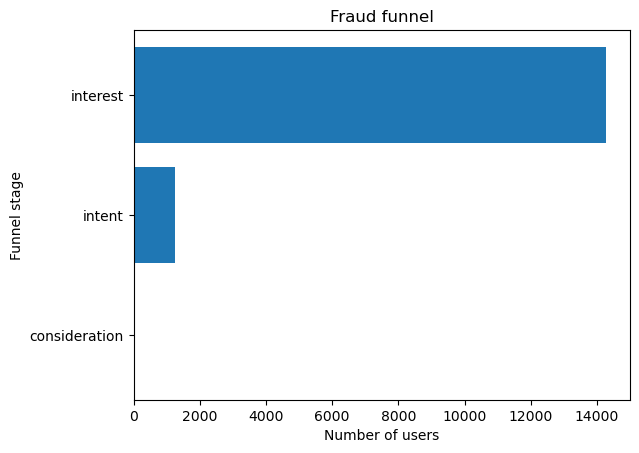

In [6]:
# Group by funnel_stage
fraud_funnel = fraud_df.groupby('funnel_stage', as_index=False).agg({'user_id': 'count'})
# Plot the funnel
plt.barh(fraud_funnel['funnel_stage'], fraud_funnel['user_id'])
plt.title('Fraud funnel')
plt.xlabel('Number of users')
plt.ylabel('Funnel stage')
plt.show()

<Axes: xlabel='timestamp', ylabel='Count'>

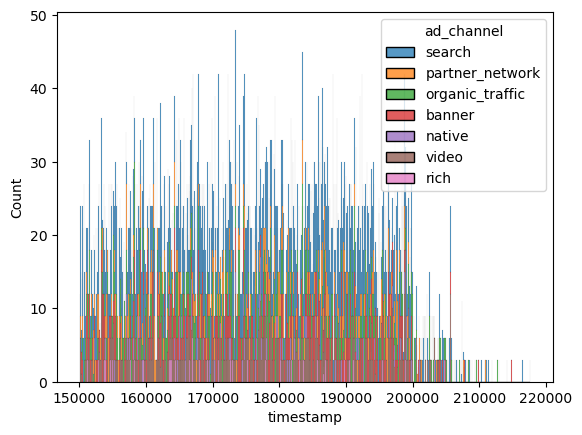

In [7]:
# Number of actions for timestamp
sns.histplot(data=fraud_df, x='timestamp', hue='ad_channel', multiple='stack', bins=1000)

In [8]:
print(f'Percentage of fraud users of the total number of users: {round(fraud_df.user_id.nunique() / df.user_id.nunique() * 100, 2)}%')

Percentage of fraud users of the total number of users: 0.82%


In [9]:
# Remove fraud data from the main dataframe
df_new = df[~df['user_id'].isin(fraud['user_id'])].sort_values('user_id').reset_index(drop=True)
df_new

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,2,interest,184320,0.0,iOS,search,1.5
1,3,interest,171761,0.0,iOS,search,1.5
2,4,interest,198271,0.0,Android,organic_traffic,0.0
3,5,consideration,202361,0.0,iOS,organic_traffic,0.0
4,5,interest,197181,0.0,Android,organic_traffic,0.0
...,...,...,...,...,...,...,...
976207,1064747,interest,174322,0.0,Android,organic_traffic,0.0
976208,1064747,consideration,171368,0.0,iOS,organic_traffic,0.0
976209,1064753,interest,166616,0.0,Android,search,1.5
976210,1064759,consideration,168820,0.0,iOS,search,1.5


<Axes: xlabel='timestamp', ylabel='Count'>

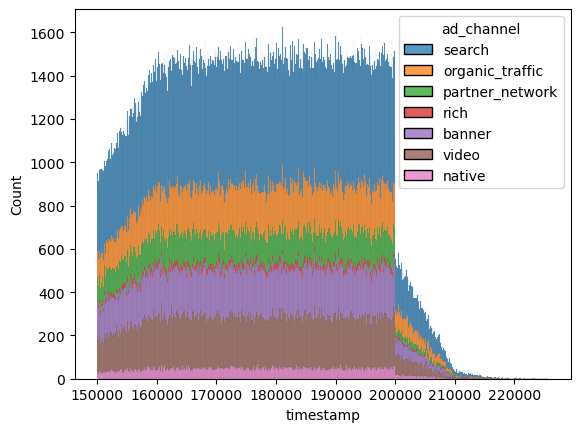

In [10]:
# Number of actions for timestamp by advertising channel
sns.histplot(data=df_new, x='timestamp', hue='ad_channel', multiple='stack', bins=1000)

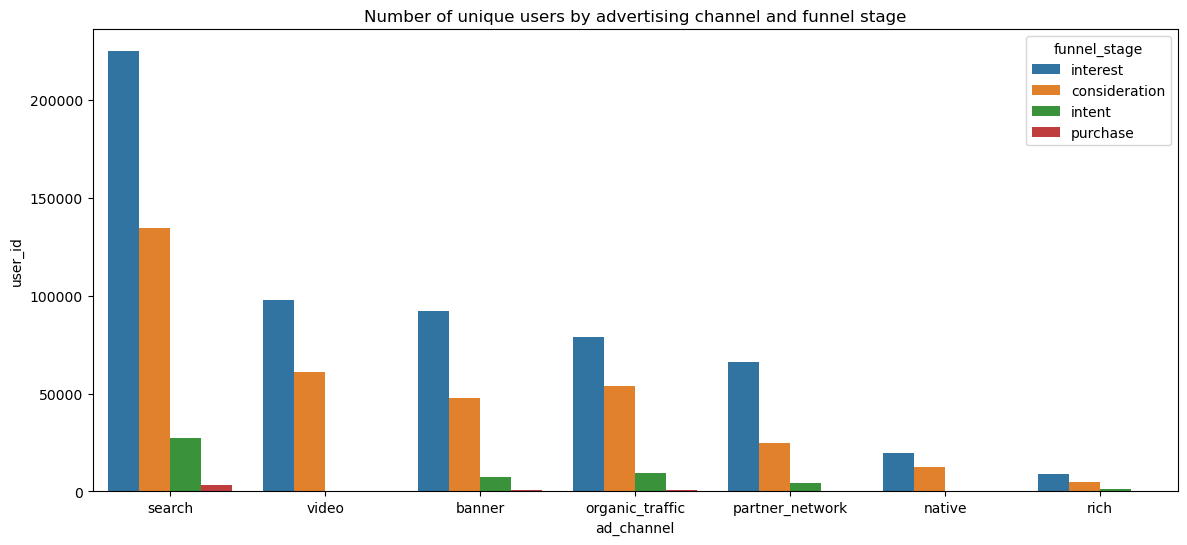

In [11]:
# Number of unique users by advertising channel and funnel stage
df_funnel = df.groupby(['ad_channel', 'funnel_stage']).agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
plt.figure(figsize=(14, 6))

sns.barplot(x='ad_channel', y='user_id', hue='funnel_stage', data=df_funnel)
plt.title('Number of unique users by advertising channel and funnel stage')
plt.show()

In [12]:
# Create table with price and profit divided by ad_channel
price_profit = df_new.groupby('ad_channel').agg({'price': 'sum', 'profit': 'sum'}).reset_index()
price_profit['benefit'] = price_profit['profit'] - price_profit['price']
price_profit = price_profit.sort_values('profit', ascending=False)
price_profit

,ad_channel,price,profit,benefit
5,search,581298.0,2112193.0,1530895.0
0,banner,73538.0,497881.0,424343.0
3,partner_network,95289.0,445411.0,350122.0
2,organic_traffic,0.0,367094.0,367094.0
1,native,64544.0,37355.0,-27189.0
4,rich,36872.5,33511.0,-3361.5
6,video,118500.0,4582.0,-113918.0


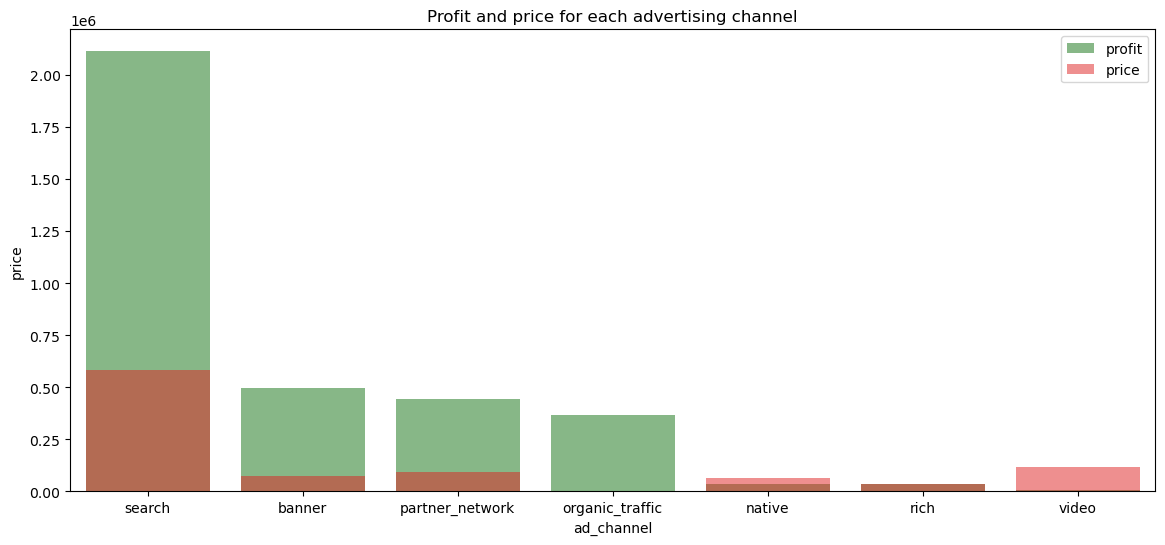

In [13]:
# Plot profit and price for each advertising channel
plt.figure(figsize=(14, 6))
sns.barplot(x='ad_channel', y='profit', data=price_profit, alpha=0.5, color='green', label='profit')
sns.barplot(x='ad_channel', y='price', data=price_profit, alpha=0.5, color='red', label='price')
plt.title('Profit and price for each advertising channel')
plt.legend(loc='upper right')
plt.show()

Video, native and rich channels show the worst performance

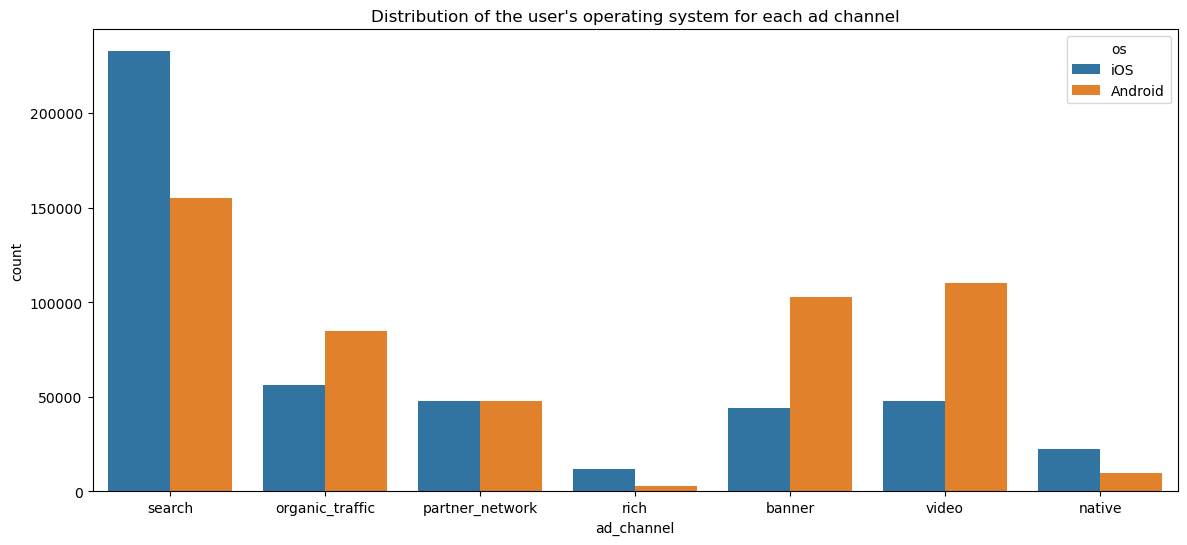

In [14]:
# Plot the distribution of the user's operating system for each ad channel
plt.figure(figsize=(14, 6))
sns.countplot(data=df_new, x='ad_channel', hue='os')
plt.title('Distribution of the user\'s operating system for each ad channel')
plt.show()

Android users are more likely to navigate through video, banner, organic_traffic channels \
iOS users are more likely to navigate through search, native, rich channels

In [15]:
# Save the dataframe to a csv file
df_new.to_csv('data/advertising_data_clean.csv', index=False)